In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
!pip install joypy
import joypy
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import matplotlib.gridspec as gridspec
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

In [3]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

In [4]:
# Check dataset shape and first rows
print(f"Dataset contains {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
train_df.head()

Dataset contains 2190 rows and 13 columns.


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0

In [5]:
print(train_df.info())  # Check data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB
None


In [6]:
train_df.describe()  # Get statistical summary

id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.948402  1013.602146    26.365799    23.953059   
std     632.342866   105.203592     5.655366     5.654330     5.222410   
min       0.000000     1.000000   999.000000    10.400000     7.400000   
25%     547.250000    89.000000  1008.600000    21.300000    19.300000   
50%    1094.500000   178.500000  1013.000000    27.800000    25.500000   
75%    1641.750000   270.000000  1017.775000    31.200000    28.400000   
max    2189.000000   365.000000  1034.600000    36.000000    31.500000   

           mintemp     dewpoint     humidity        cloud     sunshine  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean     22.170091    20.454566    82.036530    75.721918     3.744429   
std       5.059120     5.288406     7.800654    18.026498     3.626327   
min       4.000000    -0.300000    39.000000     2.000000     0.000000   
25%      17.700000    16.800000    77.000000    69.000000     0.400000   
50%      23.850000    22.150000    82.000000    83.000000     2.400000   
75%      26.400000    25.000000    88.000000    88.000000     6.800000   
max      29.800000    26.700000    98.000000   100.000000    12.100000   

       winddirection    windspeed     rainfall  
count    2190.000000  2190.000000  2190.000000  
mean      104.863151    21.804703     0.753425  
std        80.002416     9.898659     0.431116  
min        10.000000     4.400000     0.000000  
25%        40.000000    14.125000     1.000000  
50%        70.000000    20.500000     1.000000  
75%       200.000000    27.900000     1.000000  
max       300.000000    59.500000     1.000000

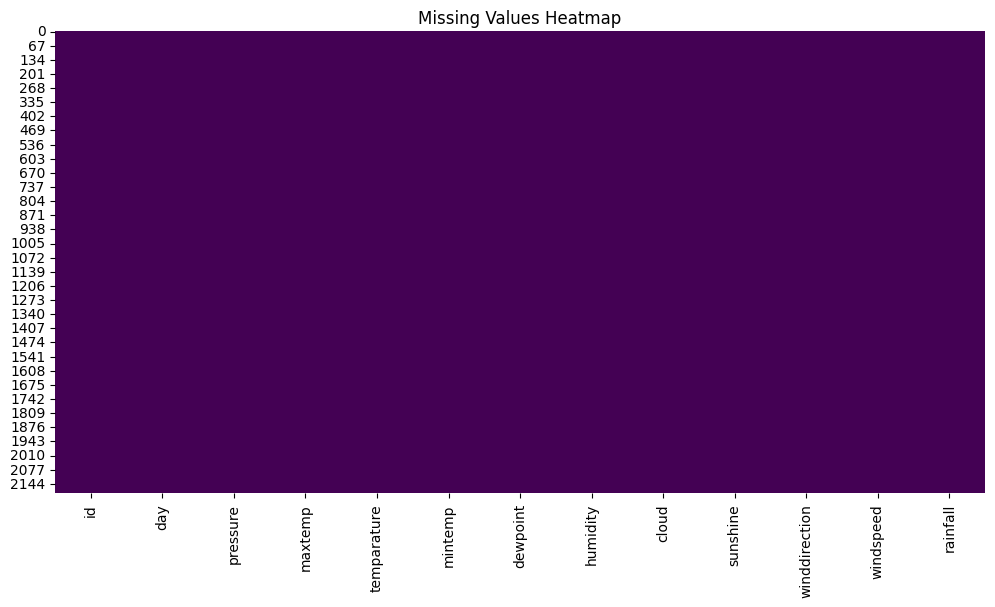

In [7]:
# Visualizing missing values (if any)
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [8]:
# Save 'id' column for submission
test_ids = test_df['id']

# Define the target column
target_column = "rainfall"

# Select categorical and numerical columns (initial)
numerical_columns = [col for col in train_df.columns if col != "rainfall"]

# Print out column information
print("Target Column:", target_column)
print("\nNumerical Columns:", numerical_columns)

Target Column: rainfall

Numerical Columns: ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


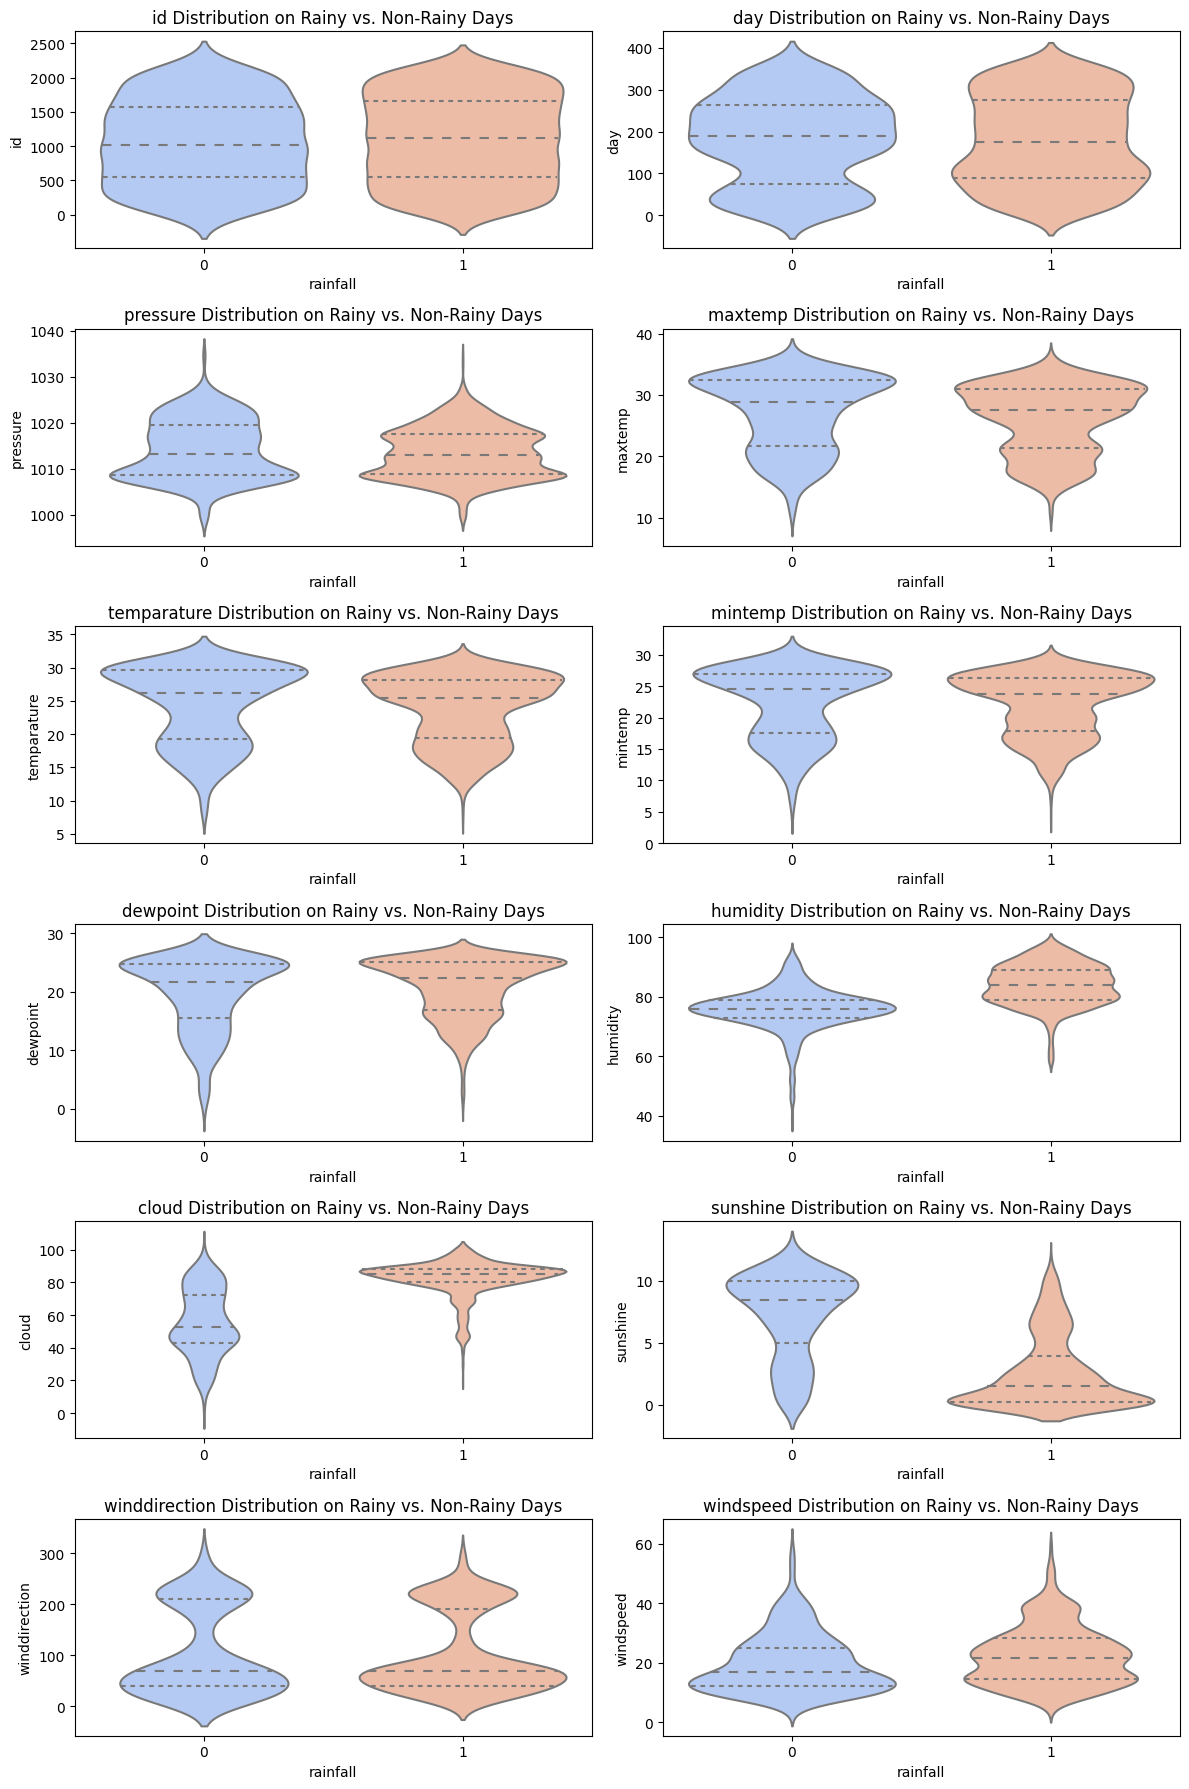

In [9]:
# Dynamically calculate number of rows & columns
num_vars = len(numerical_columns)
num_cols = 2  # Keep 2 columns for readability
num_rows = math.ceil(num_vars / num_cols)  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 18))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot violin plots
for i, var in enumerate(numerical_columns):
    sns.violinplot(x=train_df[target_column], y=train_df[var], palette="coolwarm", inner="quartile", ax=axes[i])
    axes[i].set_title(f"{var} Distribution on Rainy vs. Non-Rainy Days")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()

## 🌧️ Violin Plot Analysis: Rainy vs. Non-Rainy Days  

### **Key Observations**  

✅ **Pressure & Humidity**  
- Lower **pressure** and higher **humidity** strongly correlate with rainfall.  

✅ **Temperature & Dew Point**  
- **Temperature alone** is not a strong predictor, but **dew point** shows clearer separation.  

✅ **Sunshine & Cloud Cover**  
- **Sunshine drops significantly** on rainy days.  
- **Cloud cover** is one of the **strongest predictors** of rainfall.  

✅ **Wind Speed & Wind Direction**  
- **Higher wind variability** on rainy days, suggesting **storm-driven winds**.  
- **Bimodal wind direction**, indicating distinct weather regimes.  

✅ **Day (Time Effect)**  
- **Non-uniform distribution**, suggesting **seasonality** in rainfall patterns.  

✅ **ID (Index Feature)**  
- **No predictive power**, should be removed from modeling.  

### 🚀 **Next Steps**  
- Perform **time-series decomposition** to analyze **seasonal rainfall trends**.  

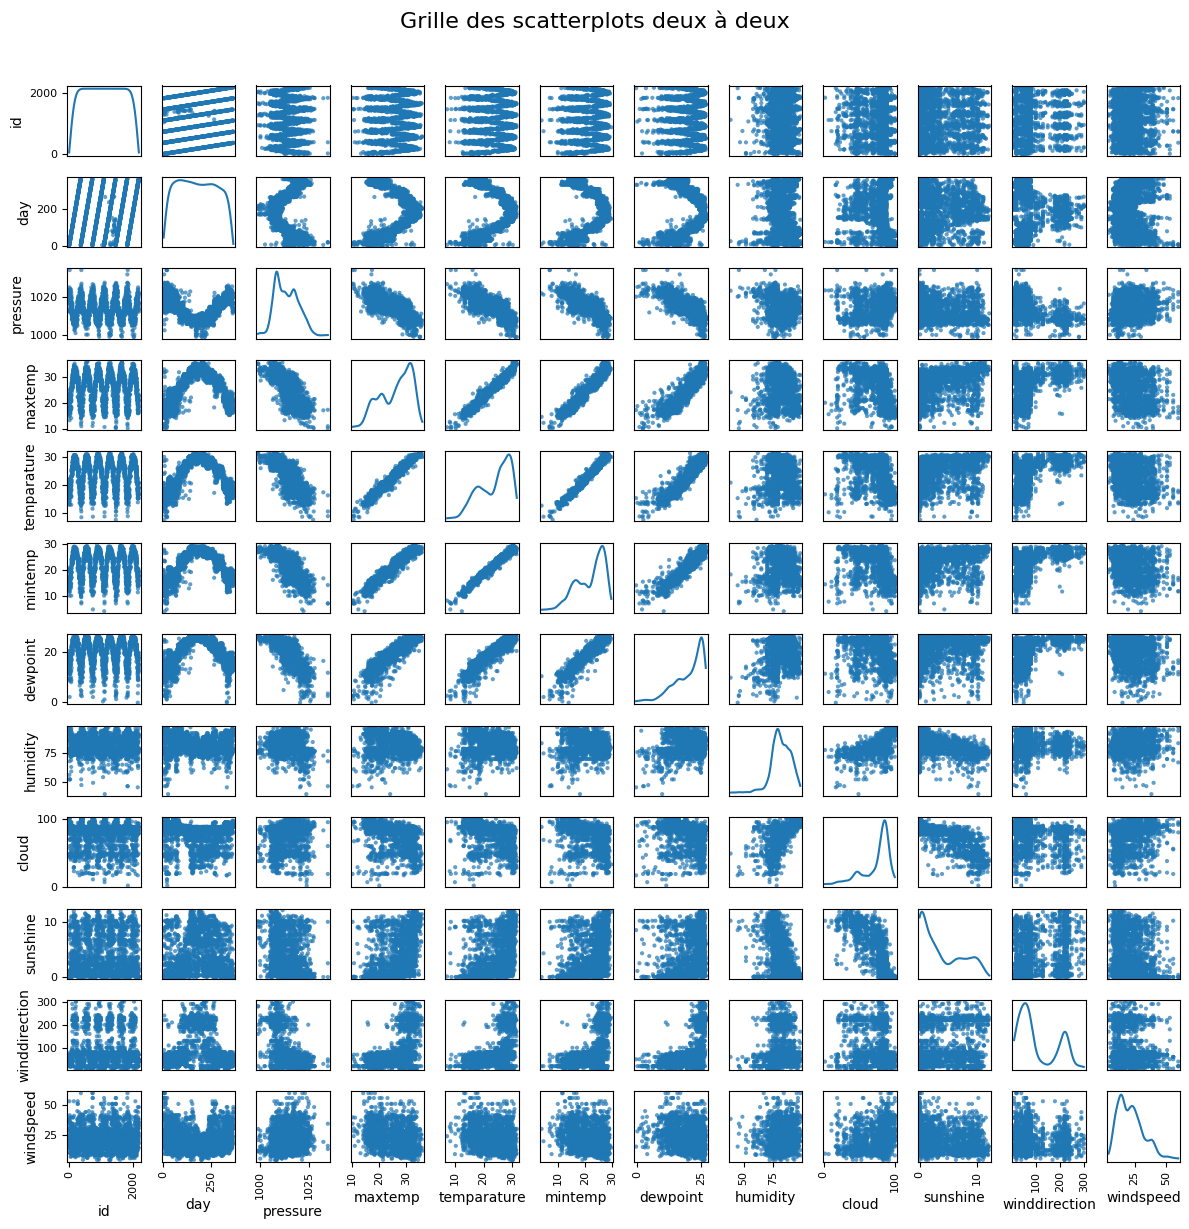

In [10]:
# Grille des scatterplots deux à deux pour visualiser les corrélations
pd.plotting.scatter_matrix(train_df[numerical_columns], figsize=(12, 12), diagonal='kde', alpha=0.7)

# Ajouter un titre général à la grille
plt.suptitle("Grille des scatterplots deux à deux", fontsize=16, y=1.02)

# Afficher le graphique
plt.tight_layout()
plt.show()

In [11]:
def detect_outliers_iqr(df, column):
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return train_df[(train_df[column] < lower_bound) | (train_df[column] > upper_bound)]

# Checking for outliers in each variable
outlier_counts = {var: len(detect_outliers_iqr(train_df, var)) for var in numerical_columns}
print(outlier_counts)

{'id': 0, 'day': 0, 'pressure': 4, 'maxtemp': 0, 'temparature': 0, 'mintemp': 1, 'dewpoint': 26, 'humidity': 28, 'cloud': 129, 'sunshine': 0, 'winddirection': 0, 'windspeed': 28}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


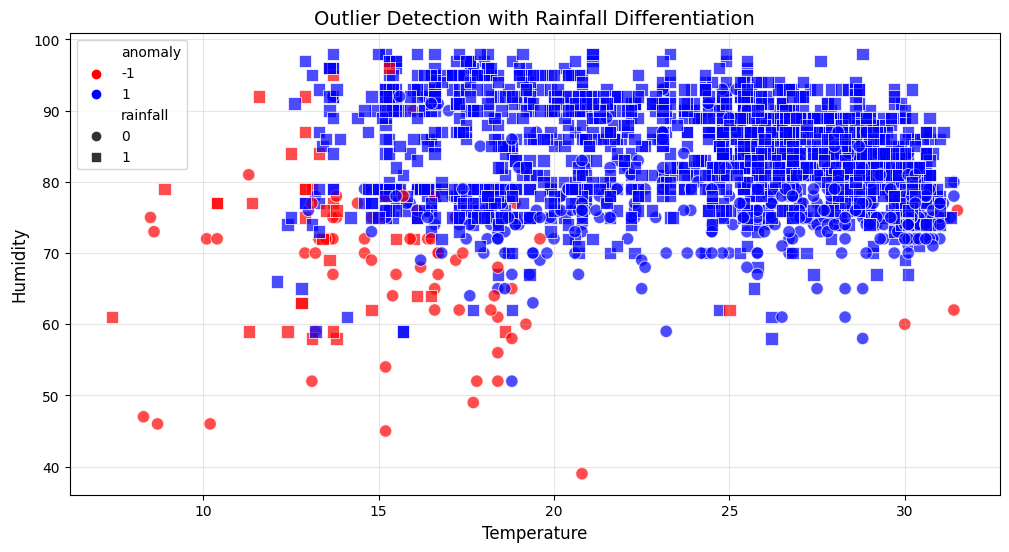

In [12]:
# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
train_df["anomaly"] = iso_forest.fit_predict(train_df[numerical_columns])

# Visualization: Differentiate by rainfall and anomaly
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_df["temparature"], 
    y=train_df["humidity"], 
    hue=train_df["anomaly"],  # Color based on anomaly (-1 = outlier, 1 = normal)
    style=train_df["rainfall"],  # Shape based on rainfall (0 = no rain, 1 = rain)
    palette={1: "blue", -1: "red"},  # Blue for normal, red for outliers
    markers={0: "o", 1: "s"},  # Circles for no rain, squares for rain
    s=80,  # Adjust marker size for visibility
    alpha=0.7  # Transparency for better readability
)

# Labels & Titles
plt.title("Outlier Detection with Rainfall Differentiation", fontsize=14)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Humidity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.show()


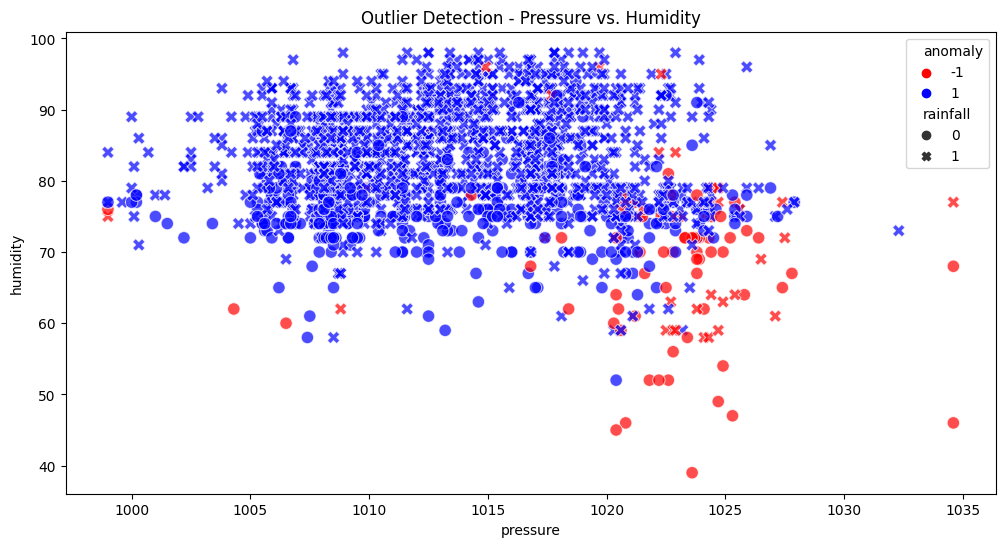

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_df["pressure"], 
    y=train_df["humidity"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"], 
    palette={1: "blue", -1: "red"}, 
    s=80, 
    alpha=0.7
)
plt.title("Outlier Detection - Pressure vs. Humidity")
plt.show()


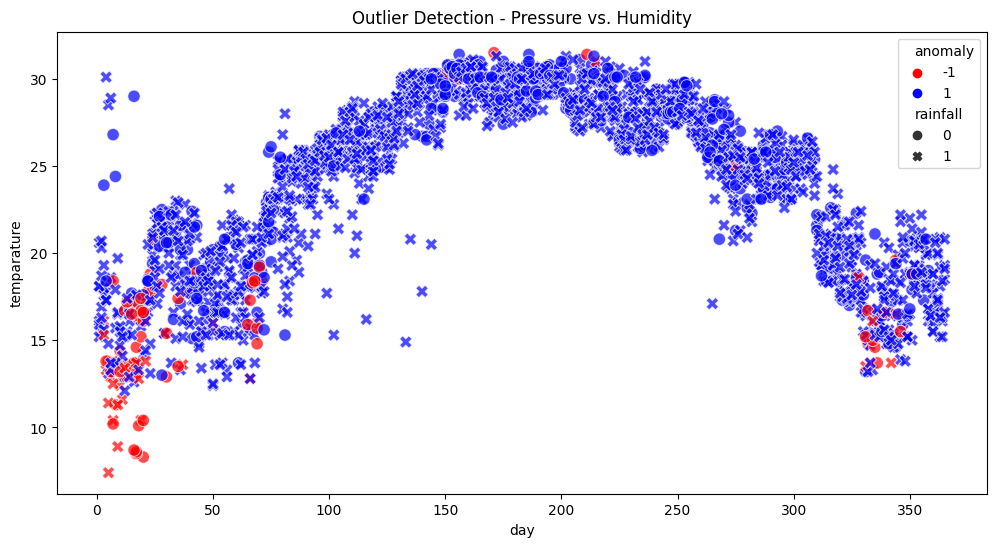

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_df["day"], 
    y=train_df["temparature"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"], 
    palette={1: "blue", -1: "red"}, 
    s=80, 
    alpha=0.7
)
plt.title("Outlier Detection - Pressure vs. Humidity")
plt.show()

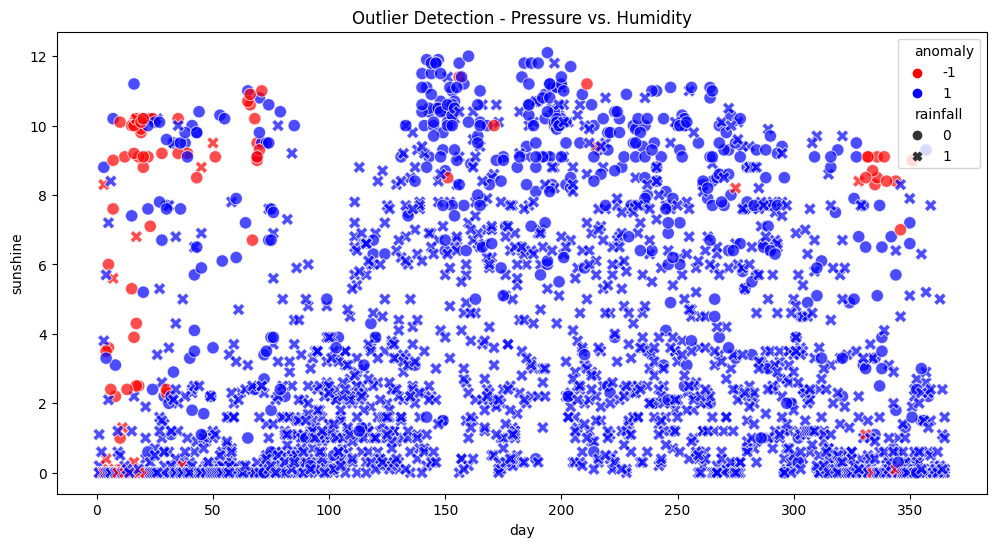

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_df["day"], 
    y=train_df["sunshine"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"], 
    palette={1: "blue", -1: "red"}, 
    s=80, 
    alpha=0.7
)
plt.title("Outlier Detection - Pressure vs. Humidity")
plt.show()

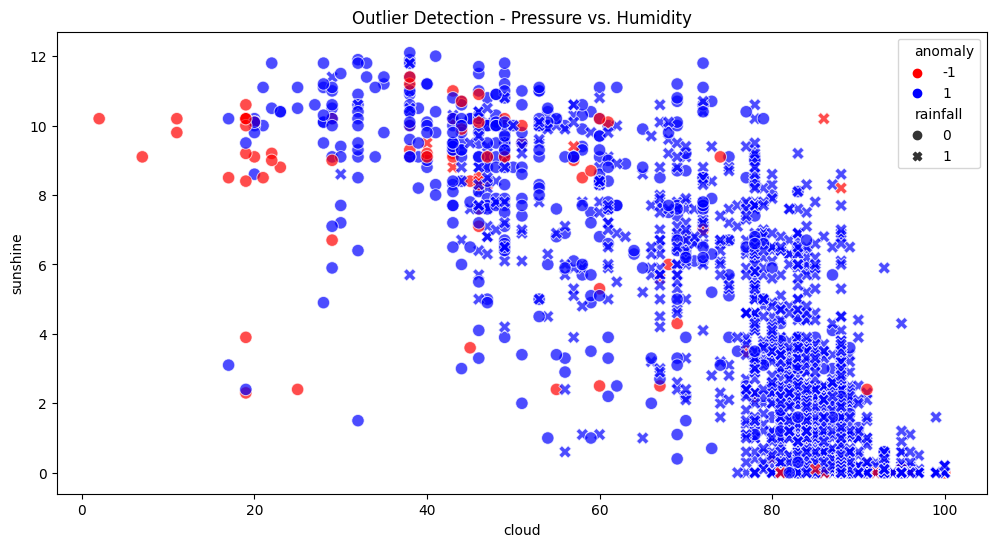

In [16]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_df["cloud"], 
    y=train_df["sunshine"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"], 
    palette={1: "blue", -1: "red"}, 
    s=80, 
    alpha=0.7
)
plt.title("Outlier Detection - Pressure vs. Humidity")
plt.show()

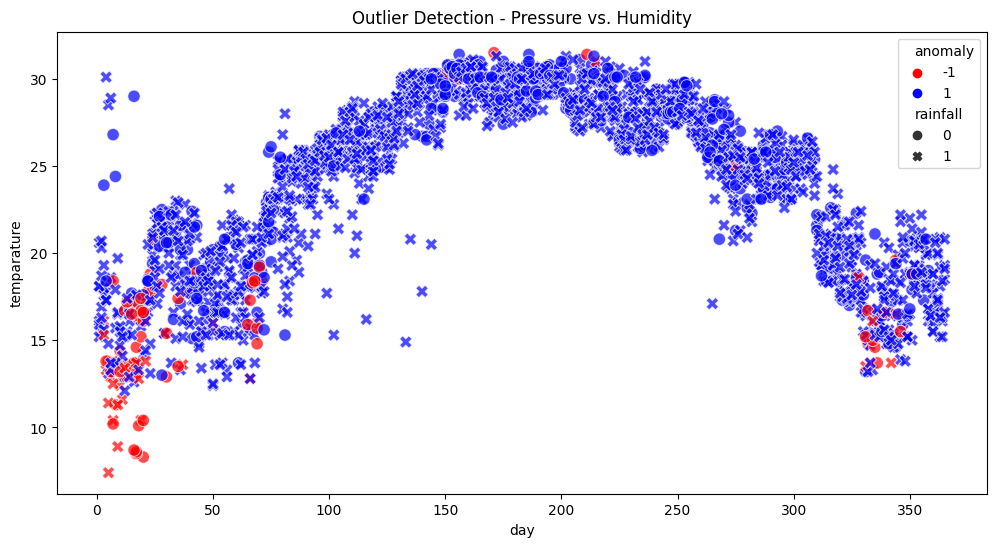

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_df["day"], 
    y=train_df["temparature"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"], 
    palette={1: "blue", -1: "red"}, 
    s=80, 
    alpha=0.7
)
plt.title("Outlier Detection - Pressure vs. Humidity")
plt.show()

In [18]:
outliers = train_df[train_df["anomaly"] == -1]
print(outliers[["temparature", "humidity", "rainfall"]].head(100))


      temparature  humidity  rainfall
2            16.1      75.0         1
4            18.4      52.0         0
6            18.4      56.0         0
7            13.6      96.0         1
9            14.4      77.0         0
...           ...       ...       ...
1839         16.5      72.0         0
1840          8.7      46.0         0
1841         13.7      59.0         1
1843         17.4      70.0         0
1844         16.6      78.0         0

[100 rows x 3 columns]


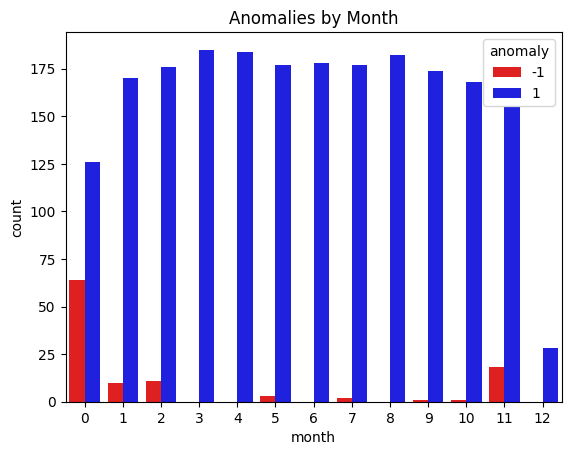

In [19]:
train_df["month"] = train_df["day"] % 365 // 30  # Approximate month calculation
sns.countplot(x=train_df["month"], hue=train_df["anomaly"], palette={1: "blue", -1: "red"})
plt.title("Anomalies by Month")
plt.show()

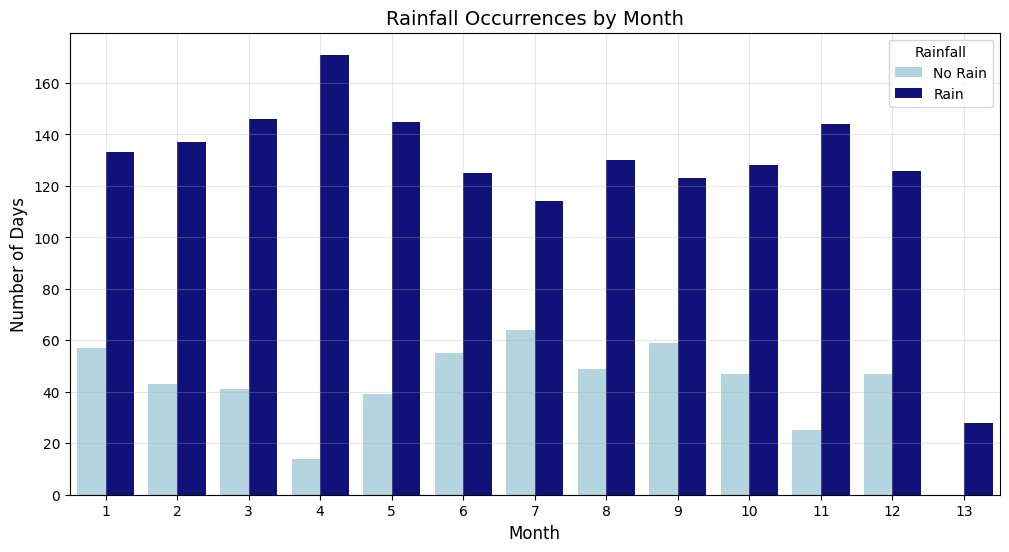

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract approximate month from 'day' (assuming a yearly cycle)
train_df["month"] = (train_df["day"] % 365) // 30 + 1  # Converts day index to a month range (1 to 12)

# Countplot of rainfall occurrences per month
plt.figure(figsize=(12, 6))
sns.countplot(x=train_df["month"], hue=train_df["rainfall"], palette={0: "lightblue", 1: "darkblue"})

# Formatting
plt.title("Rainfall Occurrences by Month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Days", fontsize=12)
plt.legend(title="Rainfall", labels=["No Rain", "Rain"])
plt.grid(alpha=0.3)

# Show plot
plt.show()


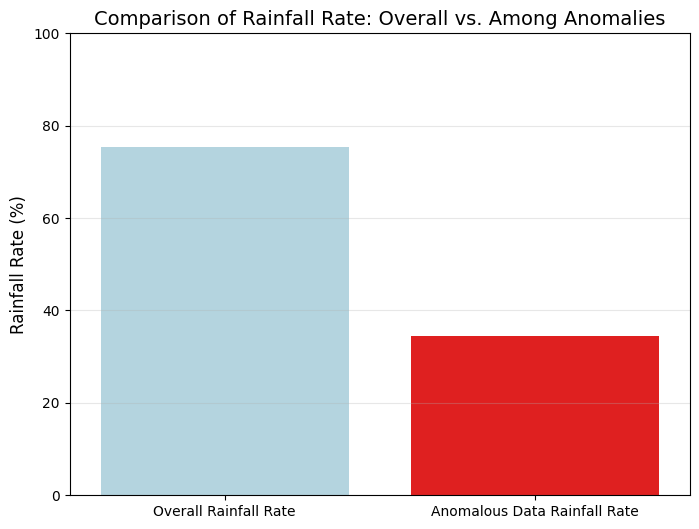

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute overall rainfall rate
global_rainfall_rate = train_df["rainfall"].mean() * 100  # Convert to percentage

# Compute rainfall rate among anomalies
anomaly_rainfall_rate = train_df[train_df["anomaly"] == -1]["rainfall"].mean() * 100  # Convert to percentage

# Create a DataFrame for visualization
rainfall_comparison = pd.DataFrame({
    "Category": ["Overall Rainfall Rate", "Anomalous Data Rainfall Rate"],
    "Rainfall Rate (%)": [global_rainfall_rate, anomaly_rainfall_rate]
})

# Plot the comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=rainfall_comparison, x="Category", y="Rainfall Rate (%)", palette=["lightblue", "red"])

# Formatting
plt.title("Comparison of Rainfall Rate: Overall vs. Among Anomalies", fontsize=14)
plt.ylabel("Rainfall Rate (%)", fontsize=12)
plt.xlabel("")
plt.ylim(0, 100)  # Ensure the scale is percentage-based
plt.grid(axis="y", alpha=0.3)

# Show plot
plt.show()


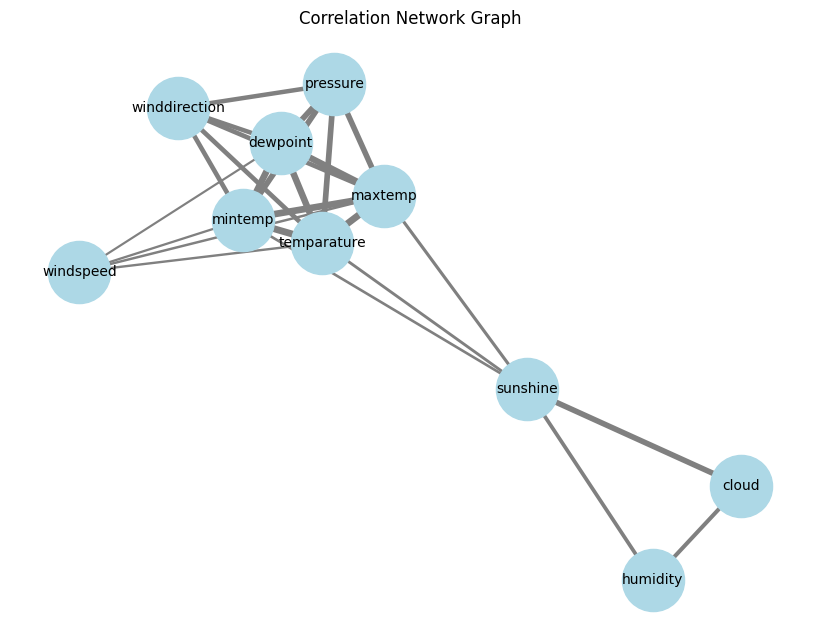

In [22]:
import networkx as nx

# Compute correlation matrix
corr_matrix = train_df[numerical_columns].corr()

# Create a network graph from correlations
G = nx.Graph()
for col in corr_matrix.columns:
    for idx in corr_matrix.index:
        if col != idx and abs(corr_matrix.loc[idx, col]) > 0.3:  # Only strong correlations
            G.add_edge(col, idx, weight=abs(corr_matrix.loc[idx, col]))

# Plot the correlation network
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)
weights = [e[2]['weight'] * 5 for e in edges]
nx.draw(G, pos, with_labels=True, edge_color="grey", node_color="lightblue", width=weights, node_size=2000, font_size=10)
plt.title("Correlation Network Graph")
plt.show()

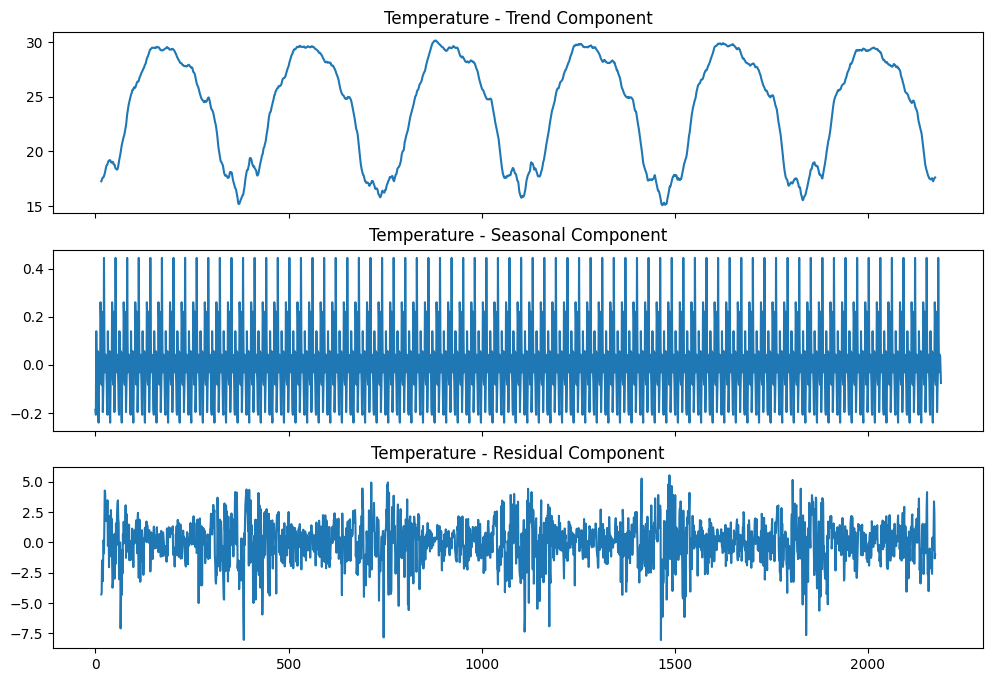

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposed = seasonal_decompose(train_df["temparature"], period=30, model="additive")

# Plot decomposition
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
decomposed.trend.plot(ax=axes[0], title="Temperature - Trend Component")
decomposed.seasonal.plot(ax=axes[1], title="Temperature - Seasonal Component")
decomposed.resid.plot(ax=axes[2], title="Temperature - Residual Component")
plt.show()

Nombre optimal de composantes pour expliquer 90% de la variance : 6


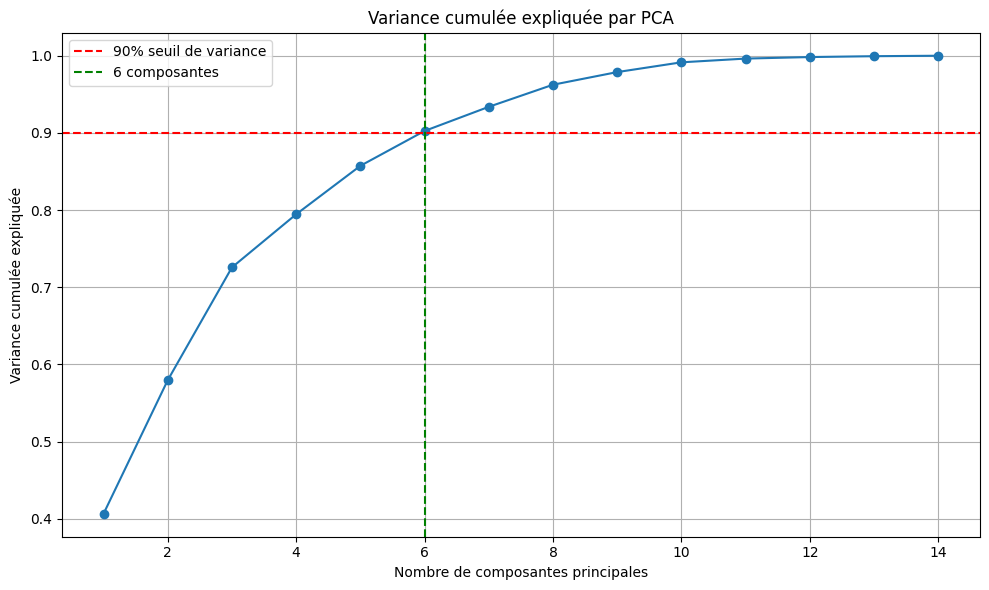

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Retirer la cible
X = train_df.drop(columns=target_column)  # modifie la cible si besoin

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA complète
pca = PCA()
pca.fit(X_scaled)

# Calcul de la variance cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Nombre optimal de composantes pour atteindre 90 %
threshold = 0.90
n_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Nombre optimal de composantes pour expliquer {threshold*100:.0f}% de la variance : {n_components}")

# Graphique explicatif
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'{threshold*100:.0f}% seuil de variance')
plt.axvline(x=n_components, color='green', linestyle='--', label=f'{n_components} composantes')

plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance cumulée expliquée')
plt.title('Variance cumulée expliquée par PCA')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# Effectuer la PCA avec le nombre optimal de composantes
pca_optimal = PCA(n_components=n_components)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

# Créer un DataFrame avec toutes les composantes PCA obtenues
pca_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X_pca_optimal, columns=pca_columns)

# (Optionnel) Ajouter la colonne cible pour analyses futures
df_pca[target_column] = train_df[target_column].values

# Afficher un aperçu des nouvelles données issues de la PCA
print(df_pca.head())


        PC1       PC2       PC3       PC4       PC5       PC6  rainfall
0  1.717768 -1.002578 -2.353216 -1.466472 -0.507511 -0.238616         1
1  3.342101 -1.634420 -2.226970 -1.456395 -0.353203 -0.327258         1
2  3.865734  4.152118 -2.639664 -1.111680  0.357698  1.911768         1
3  2.778574 -2.032656 -2.308904 -1.049208  1.058605 -0.653799         1
4  3.750881  5.038282 -2.417006 -0.848559  1.143485  1.900536         0


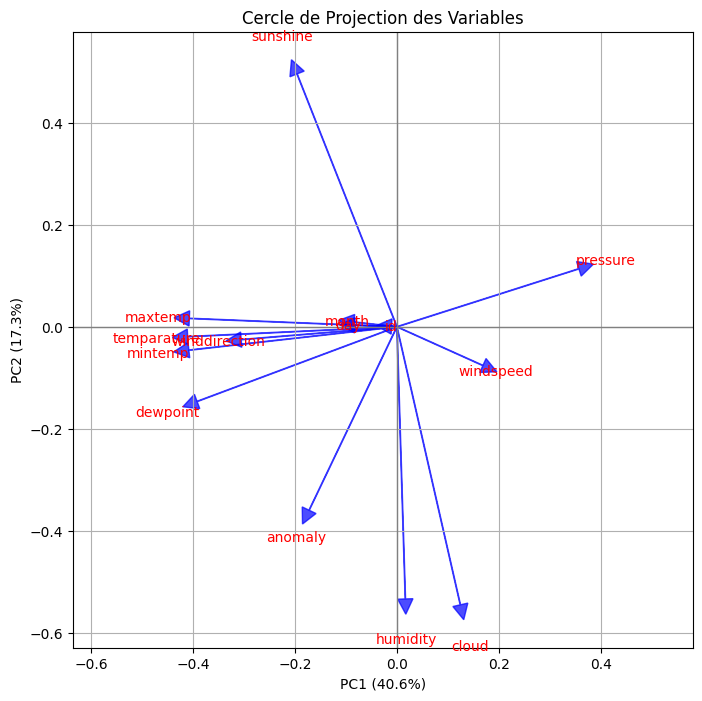

In [26]:
# Cercle de projection sur les 2 premières composantes
pcs = pca_optimal.components_

plt.figure(figsize=(8, 8))
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.arrow(0, 0, x, y, color='blue', alpha=0.7, head_width=0.03, head_length=0.03)
    plt.text(x * 1.15, y * 1.15, X.columns[i], color='red', ha='center', va='center')

# Cercle unité
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.xlabel(f'PC1 ({pca_optimal.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_optimal.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Cercle de Projection des Variables')
plt.grid(True)
plt.axis('equal')
plt.show()


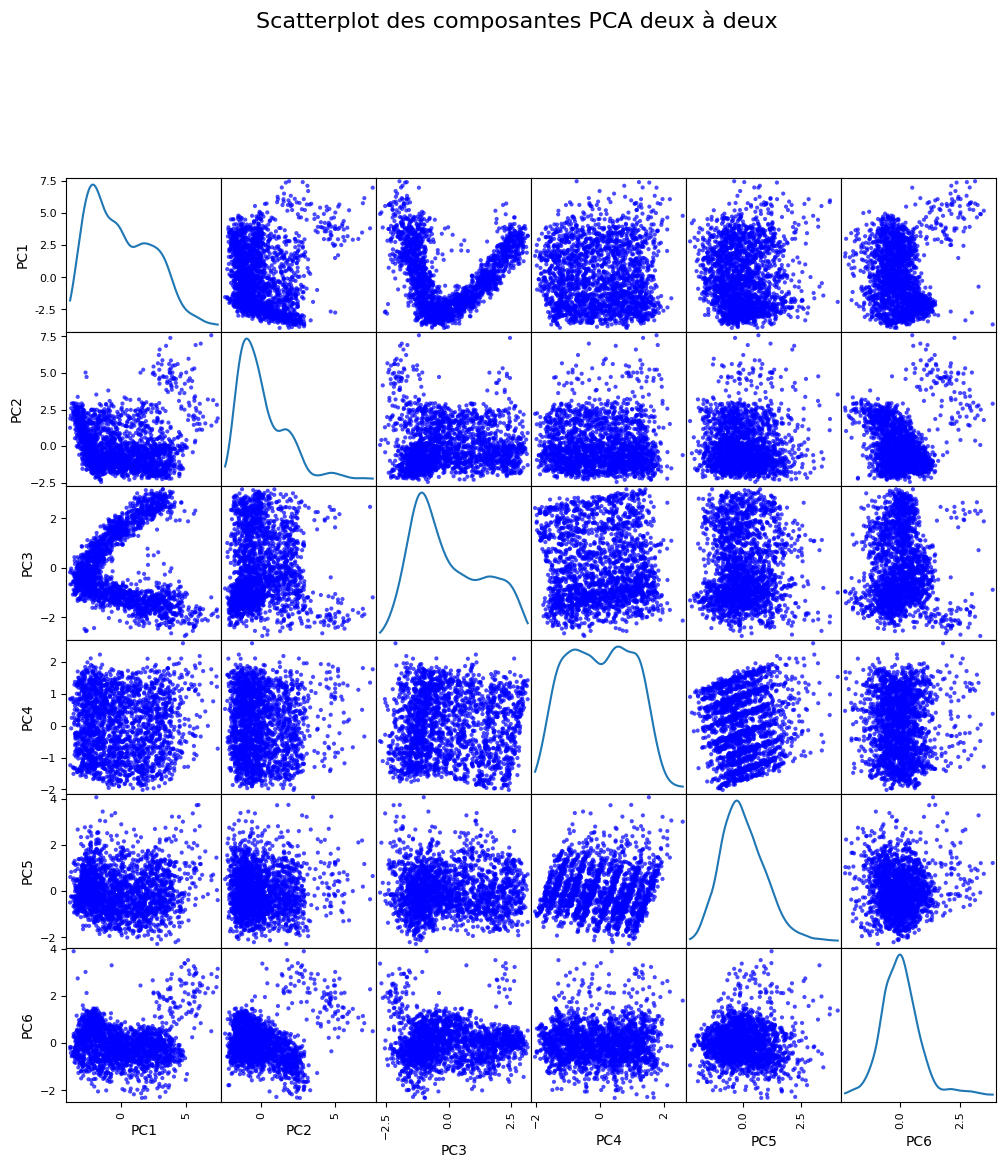

In [27]:
# Scatterplot en grille des composantes PCA deux à deux
pd.plotting.scatter_matrix(df_pca.drop(columns=[target_column]), 
                           figsize=(12, 12), 
                           diagonal='kde', 
                           alpha=0.7, 
                           c='blue')

plt.suptitle("Scatterplot des composantes PCA deux à deux", fontsize=16, y=1.02)
plt.show()


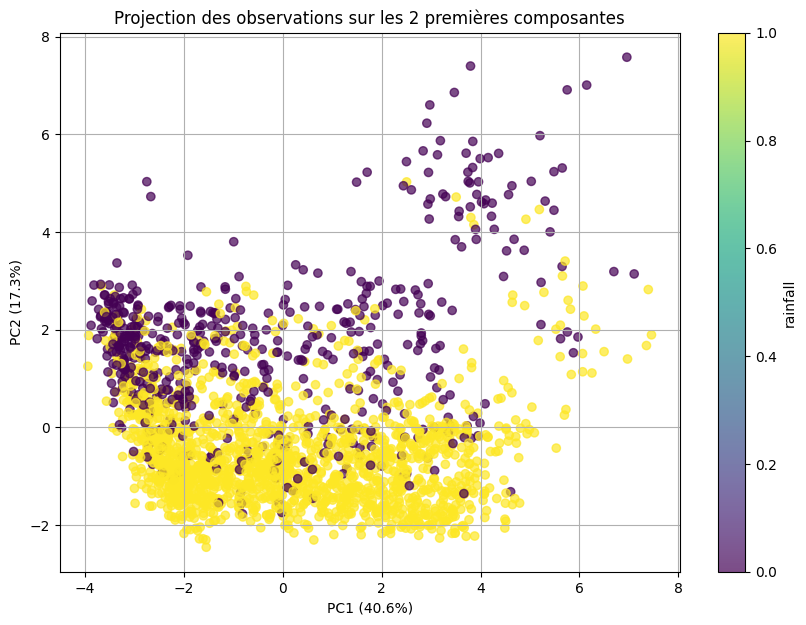

In [28]:
# Scatterplot des observations sur les 2 premières composantes
plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    X_pca_optimal[:, 0], X_pca_optimal[:, 1],
    c=train_df[target_column],  # colorer selon la cible (optionnel mais recommandé)
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label=target_column)

plt.xlabel(f'PC1 ({pca_optimal.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_optimal.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Projection des observations sur les 2 premières composantes')
plt.grid(True)
plt.show()


In [29]:
from scipy.stats import zscore

# Calculer les Z-scores sur X
z_scores = np.abs(zscore(X))

# Filtrer les observations avec Z-score inférieur à un seuil (classiquement 3)
threshold_zscore = 3
mask = (z_scores < threshold_zscore).all(axis=1)

# Appliquer le masque sur X et y
X_no_outliers = X[mask]
y_no_outliers = train_df[target_column][mask]

print(f"Nombre d'observations supprimées : {len(X) - len(X_no_outliers)}")

Nombre d'observations supprimées : 135


In [30]:
# Nouvelle standardisation après suppression des outliers
X_scaled_no_outliers = scaler.fit_transform(X_no_outliers)

# PCA avec le nombre optimal précédemment déterminé
pca_no_outliers = PCA(n_components=n_components)
X_pca_no_outliers = pca_no_outliers.fit_transform(X_scaled_no_outliers)

# Nouveau DataFrame PCA sans outliers
df_pca_no_outliers = pd.DataFrame(X_pca_no_outliers, columns=[f'PC{i+1}' for i in range(n_components)])
df_pca_no_outliers[target_column] = y_no_outliers.values

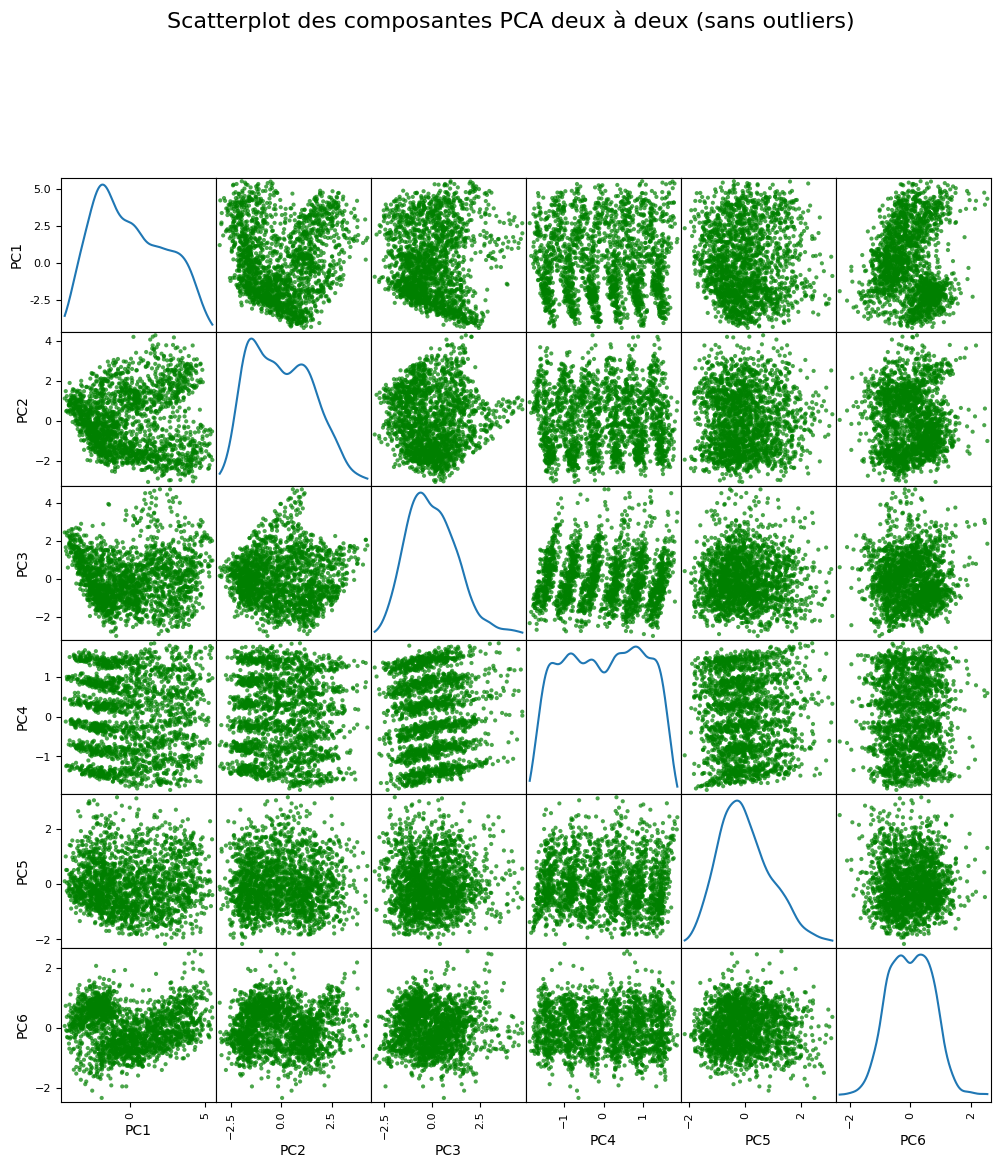

In [31]:
# Scatterplot en grille des composantes PCA deux à deux sans outliers
pd.plotting.scatter_matrix(df_pca_no_outliers.drop(columns=[target_column]),
                           figsize=(12, 12),
                           diagonal='kde',
                           alpha=0.7,
                           c='green')

plt.suptitle("Scatterplot des composantes PCA deux à deux (sans outliers)", fontsize=16, y=1.02)
plt.show()

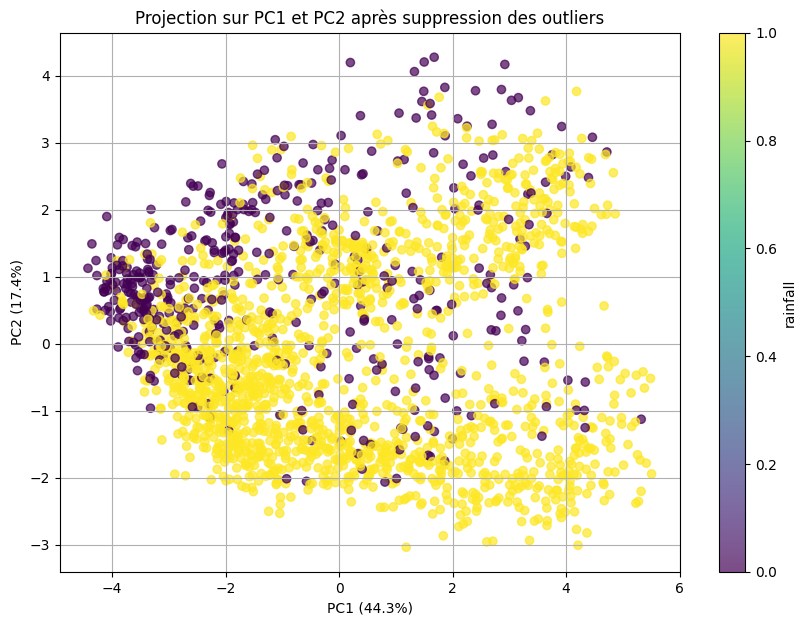

In [32]:
# Scatterplot des observations sur les deux premières composantes PCA sans outliers
plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    df_pca_no_outliers['PC1'], 
    df_pca_no_outliers['PC2'],
    c=df_pca_no_outliers[target_column],  # couleur selon la cible (optionnel mais conseillé)
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label=target_column)

plt.xlabel(f'PC1 ({pca_no_outliers.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_no_outliers.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Projection sur PC1 et PC2 après suppression des outliers')
plt.grid(True)
plt.show()

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Préparation des données (sans suppression des outliers)
X_full = train_df[numerical_columns]
y_full = train_df[target_column]

# Standardisation (recommandée pour la régression logistique)
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

# Split train/test
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full_scaled, y_full, test_size=0.3, random_state=42
)

# Entraînement du modèle
logreg_full = LogisticRegression(max_iter=1000)
logreg_full.fit(X_train_full, y_train_full)

# Prédiction
y_pred_full = logreg_full.predict(X_test_full)

# Affichage des résultats
print("Résultats sur le jeu complet (SANS suppression d'outliers, SANS PCA) :")
print(classification_report(y_test_full, y_pred_full))
print(f"Accuracy : {accuracy_score(y_test_full, y_pred_full):.2%}")

Résultats sur le jeu complet (SANS suppression d'outliers, SANS PCA) :
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       167
           1       0.89      0.94      0.91       490

    accuracy                           0.86       657
   macro avg       0.83      0.79      0.81       657
weighted avg       0.86      0.86      0.86       657

Accuracy : 86.30%


In [34]:
# ---- Régression AVANT suppression d'outliers ----
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, train_df[target_column], test_size=0.3, random_state=42
)

logreg_original = LogisticRegression(max_iter=1000)
logreg_original.fit(X_train, y_train)
y_pred_original = logreg_original.predict(X_test)

print("Résultats AVANT suppression des outliers :")
print(classification_report(y_test, y_pred_original))
print(f"Accuracy : {accuracy_score(y_test, y_pred_original):.2%}\n")

# ---- Régression APRÈS suppression d'outliers (sur les composantes PCA) ----
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    df_pca_no_outliers.drop(columns=target_column),
    df_pca_no_outliers[target_column],
    test_size=0.3, random_state=42
)

logreg_no_outliers = LogisticRegression(max_iter=1000)
logreg_no_outliers.fit(X_train_no, y_train_no)
y_pred_no = logreg_no_outliers.predict(X_test_no)

print("Résultats APRÈS suppression des outliers (sur composantes PCA) :")
print(classification_report(y_test_no, y_pred_no))
print(f"Accuracy : {accuracy_score(y_test_no, y_pred_no):.2%}")


Résultats AVANT suppression des outliers :
              precision    recall  f1-score   support

           0       0.78      0.64      0.70       167
           1       0.88      0.94      0.91       490

    accuracy                           0.86       657
   macro avg       0.83      0.79      0.81       657
weighted avg       0.86      0.86      0.86       657

Accuracy : 86.15%

Résultats APRÈS suppression des outliers (sur composantes PCA) :
              precision    recall  f1-score   support

           0       0.76      0.59      0.67       147
           1       0.88      0.94      0.91       470

    accuracy                           0.86       617
   macro avg       0.82      0.77      0.79       617
weighted avg       0.85      0.86      0.85       617

Accuracy : 85.90%


In [35]:
def date(df):
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 365)  
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 365)
    return df

# Apply the date function to both datasets
train_df = date(train_df)
test_df = date(test_df)

<div style="background-color:purple; color:white; padding:10px; border-radius:5px;">
    📊 Dataset Overview
</div>
